### Problem Statement
A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.


The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

The company wants to know:
- Which variables are significant in predicting the price of a house, and
- How well those variables describe the price of a house.

Also, determine the optimal value of lambda for ridge and lasso regression.

#### Business Goal 
You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

In [531]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

from sklearn.pipeline import make_pipeline
from sklearn import metrics


# Data display coustomization
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 100)

# hide warnings
import warnings
warnings.filterwarnings('ignore')

#### Data Visualization and Understanding

In [532]:
housing_df = pd.read_csv("train.csv")
housing_df.shape

(1460, 81)

In [453]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [533]:
# Checking how many are categorial and how many numeric variable in the given data-set
# to make sure this falls inline with the data-dictionary
housing_categorical=housing_df.select_dtypes(include=['object'])
housing_numeric=housing_df.select_dtypes(include=np.number)
print("categorical_vars:" + str(housing_categorical.columns))
print("numeric_vars:" +  str(housing_numeric.columns))

categorical_vars:Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
numeric_vars:Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
     

#### Check if the data is normally distributed against target variable `SalePrice`

In [455]:
housing_df['SalePrice'].describe().round(2)

count      1460.0
mean     180921.2
std       79442.5
min       34900.0
25%      129975.0
50%      163000.0
75%      214000.0
max      755000.0
Name: SalePrice, dtype: float64

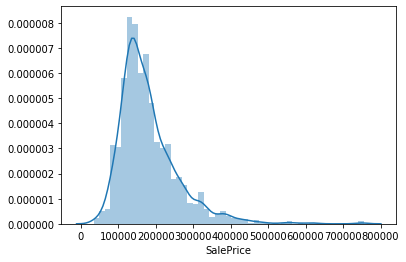

In [456]:
# from the dist plot it we can see price column is not normally distributed, the Gussian curve is scewed towards left
sns.distplot(housing_df['SalePrice'])
#plt.hist(housing_df['SalePrice'])
plt.show()

Doing a normality test on target variable `SalePrice` using `Shapiro-Wilk` normality test from scipy module

In [457]:
# perform normality test on target variable sale price
from scipy.stats import shapiro
def normality_test_price():
    stat,p = shapiro(housing_df['SalePrice'])
    alpha=0.05
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    if p > alpha:
        print('SalePrice looks following Gaussian (fail to reject Null Hypothesis H0)')
    else:
        print('SalePrice does not look following Gaussian (reject Null Hypothesis H0)')

normality_test_price()

Statistics=0.870, p=0.000
SalePrice does not look following Gaussian (reject Null Hypothesis H0)


In [458]:
# lets see how house price varies based on number of bedroom above garage
housing_df['BedroomAbvGr'].value_counts()

3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

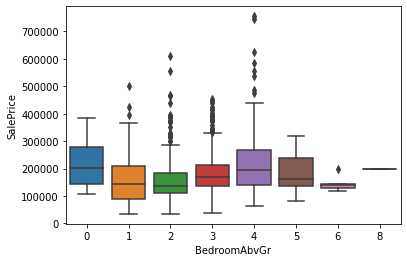

In [326]:
sns.boxplot(x='BedroomAbvGr',y='SalePrice', data=housing_df)
plt.show()

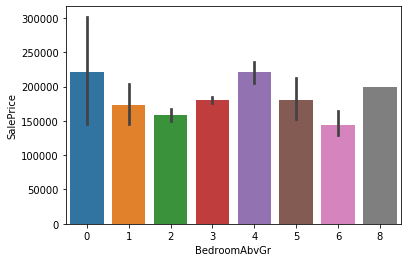

In [327]:
sns.barplot(x='BedroomAbvGr',y='SalePrice', data=housing_df)
plt.show()

Looks like there is could be some data imbalance in the data set. Ideally house price should increase as number of bedroom increases. Here the trend is beyond 4 bedrooms the house price is not creasing. There culd be multiple reason for that. One reason could be locality/neighbourhood as well. 

In [11]:
# MSZoning: Identifies the general zoning classification of the sale
housing_df['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

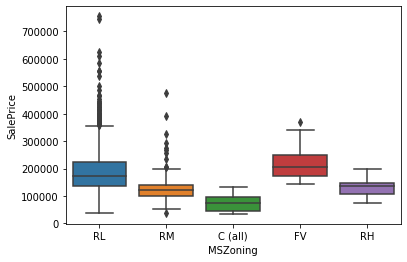

In [15]:
# Visualize how zoning relate to the target variable SalePrice 
sns.boxplot(x=housing_df['MSZoning'],y=housing_df['SalePrice'])
plt.show()

Most of the price distribution based on zoning category are lying within 400K mark. Very few residential property price is significantly high. We might need to consider those as `outliers` later.

In [19]:
# Utilities: Type of utilities available
housing_df['Utilities'].value_counts()


AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

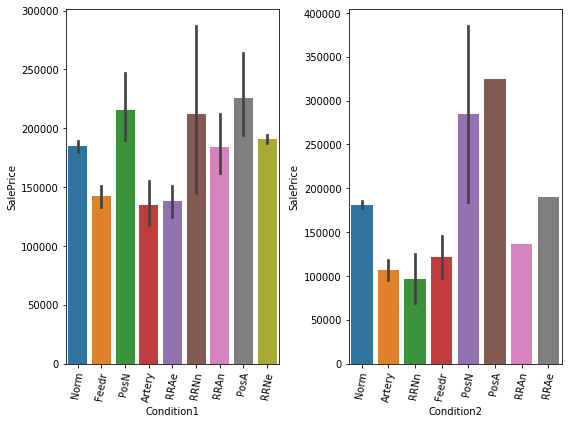

In [27]:
# Lets see how contision's are effecting sale price if any to understand if this a important factor to decide upon pricing
plt.figure(figsize=(8, 6))
plt.subplot(1,2,1)
sns.barplot(y='SalePrice',x='Condition1',data=housing_df)
plt.xticks(rotation=80)

plt.subplot(1,2,2)
sns.barplot(y='SalePrice',x='Condition2',data=housing_df)
plt.xticks(rotation=80)

plt.tight_layout()
plt.show()

In [33]:
# MSSubClass: Identifies the type of dwelling involved in the sale
housing_df['MSSubClass'].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

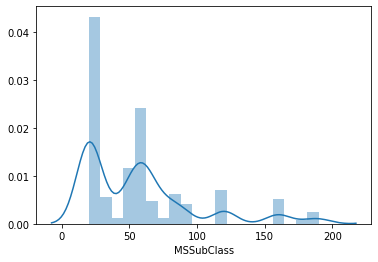

In [34]:
sns.distplot(housing_df['MSSubClass'])
plt.show()

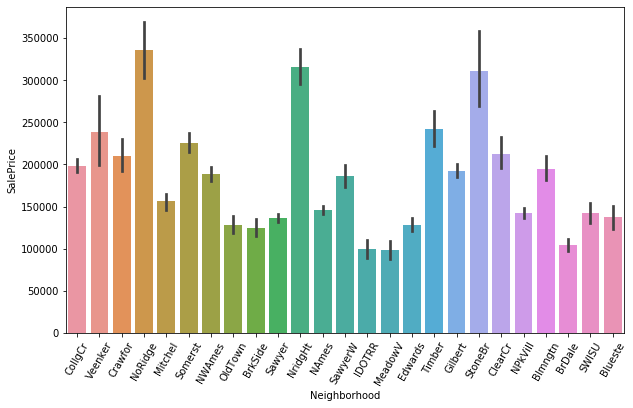

In [35]:
# Neighborhood: Physical locations within Ames city limits
plt.figure(figsize=(10, 6))
sns.barplot(y='SalePrice',x='Neighborhood',data=housing_df)
plt.xticks(rotation=60)
plt.show()

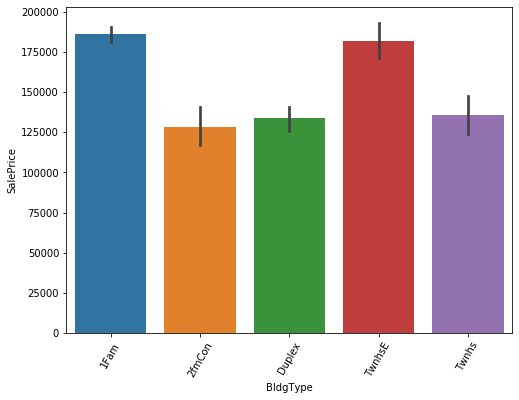

In [36]:
# BldgType: Type of dwelling
plt.figure(figsize=(8, 6))
sns.barplot(y='SalePrice',x='BldgType',data=housing_df)
plt.xticks(rotation=60)
plt.show()

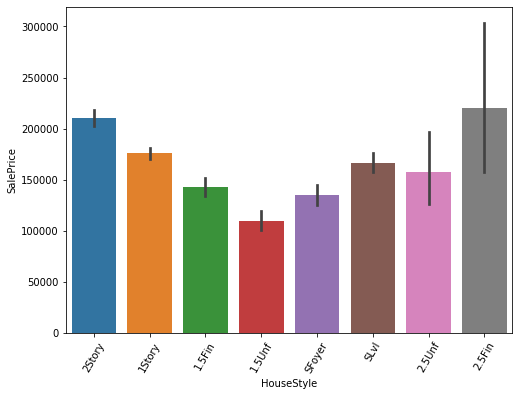

In [37]:
# HouseStyle: Style of dwelling
plt.figure(figsize=(8, 6))
sns.barplot(y='SalePrice',x='HouseStyle',data=housing_df)
plt.xticks(rotation=60)
plt.show()

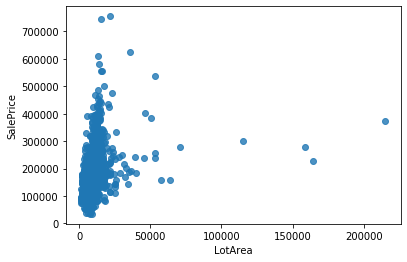

In [38]:
# LotArea: Lot size in square feet
# visualise area-price relationship
sns.regplot(x="LotArea", y="SalePrice", data=housing_df, fit_reg=False)
plt.show()

#### Data Exploration

To perform linear regression, the (numeric) target variable should be linearly related to *at least one another numeric variable*. Let's see whether that's true in this case.


We'll first subset the list of all (independent) numeric variables, and then make a **heatmap**

In [459]:
# all numeric (float and int) variables in the dataset
housing_numeric = housing_df.select_dtypes(include=['float64', 'int64'])
housing_numeric.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


In [460]:
housing_numeric.isnull().sum()

Id                 0
MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

We can drop `GarageYrBlt` and `LotFrontage` variables as from the data dictionary these does not sounds to impact much in our model

In [534]:
# dropping GarageYrBlt and LotFrontage along with ID 
housing_numeric = housing_numeric.drop(['LotFrontage','Id','GarageYrBlt'], axis=1)

In [493]:
housing_numeric['PoolArea'].value_counts()

0      1453
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64

In [42]:
housing_numeric['ScreenPorch'].value_counts()

0      1344
192       6
224       5
120       5
189       4
       ... 
182       1
440       1
178       1
312       1
480       1
Name: ScreenPorch, Length: 76, dtype: int64

In [43]:
housing_numeric['3SsnPorch'].value_counts()

0      1436
168       3
216       2
144       2
180       2
245       1
238       1
290       1
196       1
182       1
407       1
304       1
162       1
153       1
320       1
140       1
130       1
96        1
23        1
508       1
Name: 3SsnPorch, dtype: int64

As per data dictionary definition the variables `3SsnPorch`,`ScreenPorch`,`PoolArea` should have values in feet. But for most the data points these are having 0 feet which suggests either the corresponding property does not have these facilities or it has missing value. Probably we can drop such columns where majority of the value is '0'. These variables won't be significant enough for genelizing the housing price prediction. 

In [535]:
# replacing the value 0 with NaN to find how much percentage of such 0 value variables are there
for col in housing_numeric.columns:
    #print(col)
    housing_numeric[col].replace(0,np.NaN,inplace=True)
#housing_numeric.isnull().sum()

In [536]:
nullcols=(100*(housing_numeric.isnull().sum()/len(housing_numeric.index)).round(2)).sort_values(ascending=False)
nullcols[nullcols>0]

PoolArea         100.0
3SsnPorch         98.0
LowQualFinSF      98.0
MiscVal           96.0
BsmtHalfBath      94.0
ScreenPorch       92.0
BsmtFinSF2        89.0
EnclosedPorch     86.0
HalfBath          63.0
MasVnrArea        60.0
BsmtFullBath      59.0
2ndFlrSF          57.0
WoodDeckSF        52.0
Fireplaces        47.0
OpenPorchSF       45.0
BsmtFinSF1        32.0
BsmtUnfSF          8.0
GarageCars         6.0
GarageArea         6.0
TotalBsmtSF        3.0
FullBath           1.0
dtype: float64

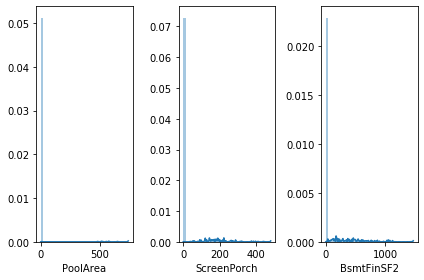

In [357]:
# for example check the distribusion of PoolArea, ScreenPorch, BsmtFinSF2 from original data set 
#plt.figure(figsize=(8, 6))
plt.subplot(1,3,1)
sns.distplot(housing_df['PoolArea'])

plt.subplot(1,3,2)
sns.distplot(housing_df['ScreenPorch'])

plt.subplot(1,3,3)
sns.distplot(housing_df['BsmtFinSF2'])
plt.tight_layout()
plt.show()


From the above analysis we can clearly drop columns where encoded NaN for corresponding 0 value is more than 89% in data set


In [407]:
nullcols[nullcols>88]
#

PoolArea        100.0
3SsnPorch        98.0
LowQualFinSF     98.0
MiscVal          96.0
BsmtHalfBath     94.0
ScreenPorch      92.0
BsmtFinSF2       89.0
dtype: float64

In [537]:
housing_numeric.drop(columns=['PoolArea','3SsnPorch','LowQualFinSF','MiscVal','BsmtHalfBath','ScreenPorch','BsmtFinSF2'],
                     axis=1,inplace=True)

In [538]:
# Now check for other null/missing values
nullcols=housing_numeric.isnull().sum()
nullcols[nullcols>0]

MasVnrArea        869
BsmtFinSF1        467
BsmtUnfSF         118
TotalBsmtSF        37
2ndFlrSF          829
BsmtFullBath      856
FullBath            9
HalfBath          913
BedroomAbvGr        6
KitchenAbvGr        1
Fireplaces        690
GarageCars         81
GarageArea         81
WoodDeckSF        761
OpenPorchSF       656
EnclosedPorch    1252
dtype: int64

In [410]:
#housing_numeric['EnclosedPorch'].median()
housing_numeric['BsmtFullBath'].mean()

1.0281456953642385

In [539]:
# impute the null/missing values with median of the corresponding data points 
for col in nullcols.index:
    housing_numeric[col].fillna(housing_numeric[col].median(), inplace=True)
nullcols=housing_numeric.isnull().sum()
nullcols[nullcols>0]    

Series([], dtype: int64)

There are few variables which has `year` column. We need to encode the year column to include that into the model creation, otherwise year values such as 1995, 2000, 1970 etc mignt effect the overall model performance. We can get a diff of these year column from the current year 2019 and process those


In [540]:
# processing year columns 
for yrCol in housing_numeric.columns:
    if str(yrCol).startswith('Year') or str(yrCol).startswith('Yr'):
        #print(yrCol)
        housing_numeric[yrCol]=housing_numeric[yrCol].astype(int)
        housing_numeric[yrCol+str('_diff_todate')]=housing_numeric[yrCol].apply(lambda x: int(2019)-int(x))
        housing_numeric.drop(columns=[yrCol],axis=1,inplace=True)
housing_numeric.head()        

,MSSubClass,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,MoSold,SalePrice,YearBuilt_diff_todate,YearRemodAdd_diff_todate,YrSold_diff_todate
0,60,8450,7,5,196.0,706.0,150.0,856.0,856,854.0,1710,1.0,2.0,1.0,3.0,1.0,8,1.0,2.0,548.0,171.0,61.0,144.5,2,208500,16,16,11
1,20,9600,6,8,203.0,978.0,284.0,1262.0,1262,776.0,1262,1.0,2.0,1.0,3.0,1.0,6,1.0,2.0,460.0,298.0,63.0,144.5,5,181500,43,43,12
2,60,11250,7,5,162.0,486.0,434.0,920.0,920,866.0,1786,1.0,2.0,1.0,3.0,1.0,6,1.0,2.0,608.0,171.0,42.0,144.5,9,223500,18,17,11
3,70,9550,7,5,203.0,216.0,540.0,756.0,961,756.0,1717,1.0,1.0,1.0,3.0,1.0,7,1.0,3.0,642.0,171.0,35.0,272.0,2,140000,104,49,13
4,60,14260,8,5,350.0,655.0,490.0,1145.0,1145,1053.0,2198,1.0,2.0,1.0,4.0,1.0,9,1.0,3.0,836.0,192.0,84.0,144.5,12,250000,19,19,11


In [421]:
# check the heatmap now for correlation of numeric variables
cor = housing_numeric.corr()
#cor

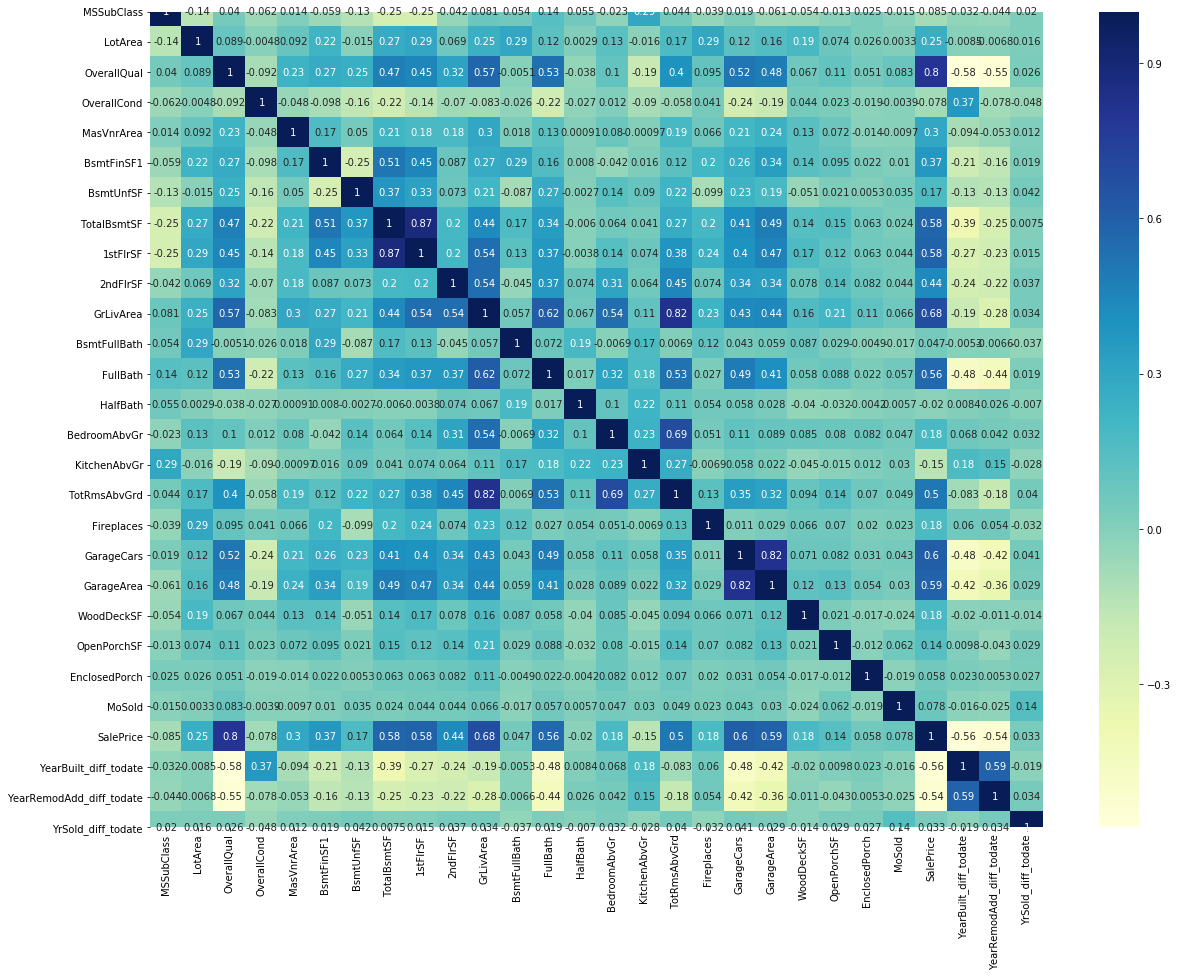

In [422]:
# figure size
plt.figure(figsize=(20,15))

# heatmap
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

We can see SalesPrice has high corelation with variables like 

- GarageArea: Size of garage in square feet
- GarageCars: Size of garage in car capacity
- GrLivArea: Above grade (ground) living area square feet
- 1stFlrSF: First Floor square feet
- 2ndFlrSF: Second floor square feet

There are multicolinearity as well like GarageCars highly correlated with GarageArea which is obvious

In [541]:
# check the null/missing values in categorical variables
nullcols=housing_categorical.isnull().sum()
nullcols[nullcols>0]

Alley           1369
MasVnrType         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [542]:
#drop the columns which has high count of null or missing values
housing_categorical.drop(columns=['Alley','Fence','PoolQC','MiscFeature'], axis=1, inplace=True)

In [544]:
nullcols=housing_categorical.isnull().sum()
nullcols[nullcols>0]

MasVnrType        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     690
GarageType       81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

Except `Electrical` all the other above variables can be imputed with no value like 'NA' or 'None' 

In [545]:
null_col_to_impute=nullcols[nullcols>1]
for col in null_col_to_impute.index:
    if col == "MasVnrType":
        housing_categorical[col].fillna("None", inplace=True)
    else:
        housing_categorical[col].fillna("NA", inplace=True)

In [546]:
nullcols=housing_categorical.isnull().sum()
nullcols[nullcols>0]

Electrical    1
dtype: int64

In [547]:
housing_categorical['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [548]:
# Imputing the row with Unknown for missing value for E;ectrical variable
#housing_categorical=housing_categorical[~np.isnan(housing_categorical['Electrical'])]
housing_categorical['Electrical'].fillna('Unknown', inplace=True)

There are rating or quality related categorical variable whose values are having abbreviation like Ex for Excellent, Gd for Good etc. Where as the similar numerical variables like `OverallQual`, `OverallCond` has integer values for such ratings. We should encode such categorical variables like `ExterQual`, `ExterCond`,`BsmtQual`, `BsmtCond` etc in numeric format like `OverallQual`, `OverallCond`.

In [430]:
housing_categorical['BsmtQual'].value_counts()

TA    649
Gd    618
Ex    121
NA     37
Fa     35
Name: BsmtQual, dtype: int64

In [431]:
housing_categorical['FireplaceQu'].value_counts()

NA    690
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [549]:
print(housing_categorical.shape[1])
print(housing_numeric.shape[1])

39
28


In [550]:
varlist =  ['BsmtQual', 'BsmtCond', 'ExterQual','ExterCond',
            'FireplaceQu','KitchenQual','HeatingQC']

# Defining the map function
def encode_cat_to_numeric(x):
    return x.map({'Ex': 9, "Gd": 7, "TA": 5, 'Fa': 3, 'NA': 0, 'Po': 2})

# Applying the function to the housing list
housing_numeric[varlist] = housing_categorical[varlist].apply(encode_cat_to_numeric)
for var in varlist:
    housing_numeric[var]=housing_numeric[var].astype(int)
    housing_categorical.drop([var], axis=1, inplace=True)
    
print(housing_categorical.shape[1])
print(housing_numeric.shape[1])   

32
35


#### Data preparation

Now its time to process the categorical variables by creating dummies 

In [552]:
housing_dummies = pd.get_dummies(housing_categorical, drop_first=True)
housing_dummies.tail()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,...,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Electrical_Unknown,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1455,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1456,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1457,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1458,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1459,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


In [553]:
housing_dummies.shape

(1460, 184)

In [562]:
# Concatenating all processed numerical and processed dummies for categorical
# This is the data set we will use going forward for model building
model_df = pd.concat([housing_numeric, housing_dummies], axis=1)
model_df.shape

(1460, 219)

In [561]:
model_df.isnull().sum()

MSSubClass                  14
LotArea                     14
OverallQual                 14
OverallCond                 14
MasVnrArea                  14
BsmtFinSF1                  14
BsmtUnfSF                   14
TotalBsmtSF                 14
1stFlrSF                    14
2ndFlrSF                    14
GrLivArea                   14
BsmtFullBath                14
FullBath                    14
HalfBath                    14
BedroomAbvGr                14
KitchenAbvGr                14
TotRmsAbvGrd                14
Fireplaces                  14
GarageCars                  14
GarageArea                  14
WoodDeckSF                  14
OpenPorchSF                 14
EnclosedPorch               14
MoSold                      14
SalePrice                   14
YearBuilt_diff_todate       14
YearRemodAdd_diff_todate    14
YrSold_diff_todate          14
BsmtQual                    14
BsmtCond                    14
ExterQual                   14
ExterCond                   14
Fireplac

In [564]:
# because of the concat for some reason I'm getting 14 rows of NaN values in the merged data set model_df
# to adjust removing those rows
model_df=model_df[~np.isnan(model_df['MSSubClass'])]
#model_df.isnull().sum()

In [570]:
model_df.shape

(1460, 219)

In [565]:
# split X and y 
y = model_df.loc[:, 'SalePrice']
X = model_df.loc[:, model_df.columns != 'SalePrice']


In [566]:
# Scale the features using StnadardScaler
# scale
scaler = StandardScaler()
#scaler.fit(X)
scaler.fit_transform(X)

array([[ 0.07337496, -0.20714171,  0.65147924, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-0.87256276, -0.09188637, -0.07183611, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [ 0.07337496,  0.07347998,  0.65147924, ..., -0.11785113,
         0.4676514 , -0.30599503],
       ...,
       [ 0.30985939, -0.14781027,  0.65147924, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-0.87256276, -0.08016039, -0.79515147, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-0.87256276, -0.05811155, -0.79515147, ..., -0.11785113,
         0.4676514 , -0.30599503]])

In [567]:
# split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

#### Model Building and Evaluation

Building models usoing both Ridge and Lasso technique

#### Ridge Regression

In [581]:
def ridge_n_lasso(ml_algo):
    # list of alphas to tune
    params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 25, 40, 50]}

    # cross validation
    #folds = 5
    # creating a KFold object with 5 splits 
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

    model_ridge = GridSearchCV(estimator = ml_algo, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)    
    return model_ridge


In [582]:
ridge = Ridge()
model_ridge=ridge_n_lasso(ridge)
model_ridge.fit(X_train, y_train) 

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:    2.5s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 25,
                                   40, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [583]:
ridge_results = pd.DataFrame(model_ridge.cv_results_)
ridge_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.030818,0.015069,0.006603,0.004493,0.0001,{'alpha': 0.0001},-22456.054552,-19438.182936,-22684.819371,-25493.975765,-18928.322699,-21800.913360,2394.054732,27,-12970.052380,-13994.037223,-13598.333186,-12882.337861,-13575.821352,-13404.116401,418.538826
1,0.032220,0.019469,0.003731,0.000899,0.001,{'alpha': 0.001},-22453.360296,-19383.151956,-22595.902224,-25408.684246,-18881.778236,-21745.269598,2383.248749,26,-12970.696157,-13992.134882,-13601.548730,-12886.439231,-13581.727092,-13406.509219,417.637390
2,0.012295,0.001765,0.003154,0.000602,0.01,{'alpha': 0.01},-22427.176359,-19043.353602,-22042.795278,-24732.822142,-19222.354197,-21494.614592,2135.879671,20,-12979.724271,-14082.862272,-13702.225692,-12960.079593,-13739.210362,-13492.820438,447.166279
3,0.008849,0.000643,0.002434,0.000126,0.05,{'alpha': 0.05},-22295.478273,-19325.555620,-21441.099002,-23493.625375,-21044.730001,-21520.857087,1381.148081,21,-13031.450354,-14880.977581,-14372.861857,-13464.386713,-14510.395404,-14052.014382,690.954913
4,0.009133,0.000930,0.002668,0.000248,0.1,{'alpha': 0.1},-22114.346561,-19747.681255,-21390.716805,-22970.920499,-22094.405781,-21664.055642,1080.586313,24,-13098.831496,-15446.909535,-14918.592203,-13950.062069,-15052.692339,-14493.417528,853.558924


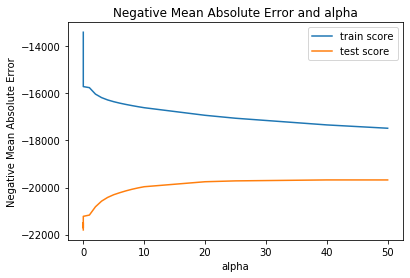

In [584]:
# plotting cv results
#ridge_results['param_alpha'] = ridge_results['param_alpha'].astype('float')
ridge_results['param_alpha'] = ridge_results['param_alpha'].astype('int32')

# plotting
plt.plot(ridge_results['param_alpha'], ridge_results['mean_train_score'])
plt.plot(ridge_results['param_alpha'], ridge_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

We see from the plot that the test negative mean absolute error first increases and then follows a static trend. But the training negative mean absolute error keeps on decreasing as we increase the value of the hyperparameter, which is in accordance with the bias-variance trade-off.

Somewhere between alpha=8-10 test performs peak, hence the final model we would generate with alpha=9 we construct the objective function and re-run the regression algorithm on entire training data. The we can have our final model with optimal features.

In [608]:
alpha = 9
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)

Ridge(alpha=9, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [609]:
# ridge predict 
y_train_pred = ridge.predict(X_train)
print("ridge train pred r2_score: " + str(metrics.r2_score(y_true=y_train, y_pred=y_train_pred)))
y_test_pred = ridge.predict(X_test)
print("ridge test pred r2_score: " + str(metrics.r2_score(y_true=y_test, y_pred=y_test_pred)))

ridge train pred r2_score: 0.8826345775619088
ridge test pred r2_score: 0.866495729272287


In [610]:
ridge_df=get_top_important_predictor_var(ridge)
ridge_df.head(5)

,feature,model_coefficients
67,Neighborhood_NridgHt,27644.272840
66,Neighborhood_NoRidge,25984.035574
113,RoofMatl_WdShngl,25917.171437
151,BsmtExposure_Gd,17864.974188
57,Neighborhood_Crawfor,14469.646771


In [611]:
# doubling the alpha for Ridge
alpha=18
ridge=Ridge(alpha=alpha)
ridge.fit(X_train,y_train)

Ridge(alpha=18, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [612]:
# ridge predict 
y_train_pred = ridge.predict(X_train)
print("ridge train pred r2_score: " + str(metrics.r2_score(y_true=y_train, y_pred=y_train_pred)))
y_test_pred = ridge.predict(X_test)
print("ridge test pred r2_score: " + str(metrics.r2_score(y_true=y_test, y_pred=y_test_pred)))

ridge train pred r2_score: 0.8754148422544542
ridge test pred r2_score: 0.8658353012848261


In [613]:
ridge_df=get_top_important_predictor_var(ridge)
ridge_df.head(5)

,feature,model_coefficients
67,Neighborhood_NridgHt,21550.333043
66,Neighborhood_NoRidge,20649.595561
151,BsmtExposure_Gd,16201.153533
113,RoofMatl_WdShngl,14563.197434
57,Neighborhood_Crawfor,11693.277195


In [575]:
# ridge model parameters
ridge_model_parameters=list(ridge.coef_)
len(ridge_model_parameters)
#ridge.intercept_

218

#### Lasso Regression

In [614]:
lasso=Lasso()
model_lasso=ridge_n_lasso(lasso)
model_lasso.fit(X_train, y_train) 

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:   19.2s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 25,
                                   40, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [615]:
lasso_results=pd.DataFrame(model_lasso.cv_results_)
lasso_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.195279,0.136348,0.002692,0.000252,0.0001,{'alpha': 0.0001},-22368.567357,-19525.384618,-22793.386088,-25461.893646,-19216.546187,-21873.640801,2302.872364,27,-12974.280179,-13995.783141,-13598.784501,-12882.114600,-13574.942427,-13405.180969,418.183243
1,0.155852,0.041877,0.005612,0.005758,0.001,{'alpha': 0.001},-22368.640773,-19524.978537,-22792.508294,-25455.048688,-19220.176162,-21872.756652,2299.920934,26,-12974.298723,-13995.780852,-13598.795261,-12882.111067,-13574.934993,-13405.184179,418.180051
2,0.130968,0.004422,0.002580,0.000090,0.01,{'alpha': 0.01},-22369.400146,-19521.072400,-22783.744932,-25465.945156,-19208.001104,-21870.122236,2306.252406,25,-12974.542494,-13995.806609,-13598.987010,-12882.230363,-13574.923104,-13405.297916,418.124045
3,0.310048,0.140838,0.003560,0.001231,0.05,{'alpha': 0.05},-22375.592085,-19502.860792,-22745.068487,-25457.009733,-19085.653621,-21833.768144,2332.892811,24,-12975.814958,-13996.133085,-13600.015773,-12882.798086,-13574.865786,-13405.925538,417.902912
4,0.303399,0.140561,0.002726,0.000201,0.1,{'alpha': 0.1},-22370.863167,-19494.363613,-22696.744522,-25445.668887,-18969.597066,-21796.011031,2354.672633,23,-12977.738835,-13996.756195,-13601.322008,-12883.633277,-13574.792197,-13406.848502,417.589606


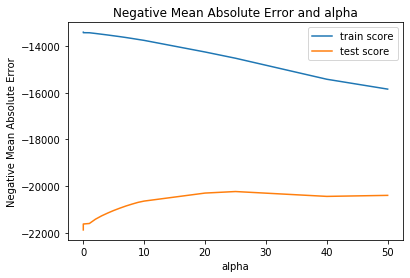

In [589]:
lasso_results['param_alpha'] = lasso_results['param_alpha'].astype('int32')

# plotting
plt.plot(lasso_results['param_alpha'], lasso_results['mean_train_score'])
plt.plot(lasso_results['param_alpha'], lasso_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [616]:
# select the optimal alpha as 9 
alpha = 9
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train)

Lasso(alpha=9, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [617]:
# lasso predict
y_train_pred = lasso.predict(X_train)
print("lasso train pred r2_score: " + str(metrics.r2_score(y_true=y_train, y_pred=y_train_pred)))
y_test_pred = lasso.predict(X_test)
print("lasso test pred r2_score: " + str(metrics.r2_score(y_true=y_test, y_pred=y_test_pred)))

lasso train pred r2_score: 0.9343831436100587
lasso test pred r2_score: 0.8312355842656285


There is a significant difference between taining and test data set r2_score in `Lasso` regression. With `lambda=9`(alpha=9) `Ridge` model suggests r2_score is 86% which is much closer match the training data set r2_score. But `Lasso` model suggests r2_score is only 83% where as training data set r2_score is 93%. This shows `Lasso` model is `underfit` with `alpha=9`

In [618]:
# top 5 predictor vaiable for lasso when alpha=9
lasso_df=get_top_important_predictor_var(lasso)
lasso_df.head(5)

,feature,model_coefficients
113,RoofMatl_WdShngl,613913.194110
108,RoofMatl_Membran,566075.792513
107,RoofMatl_CompShg,543666.861094
109,RoofMatl_Metal,539081.567614
111,RoofMatl_Tar&Grv,532691.993097


In [619]:
# adjusting the alpha to make it double 
alpha = 18
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train)

y_train_pred = lasso.predict(X_train)
print("lasso train pred r2_score: " + str(metrics.r2_score(y_true=y_train, y_pred=y_train_pred)))
y_test_pred = lasso.predict(X_test)
print("lasso test pred r2_score: " + str(metrics.r2_score(y_true=y_test, y_pred=y_test_pred)))

lasso train pred r2_score: 0.9279924910225573
lasso test pred r2_score: 0.8393765560695181


In [620]:
# top 5 predictor vaiable for lasso when alpha=18
lasso_df=get_top_important_predictor_var(lasso)
lasso_df.head(5)

,feature,model_coefficients
113,RoofMatl_WdShngl,464322.606528
107,RoofMatl_CompShg,395235.659841
108,RoofMatl_Membran,376521.872650
111,RoofMatl_Tar&Grv,370027.574375
110,RoofMatl_Roll,368979.404766


In [603]:
# adjusting the alpha to make it 18*2=36
alpha = 36
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train)

y_train_pred = lasso.predict(X_train)
print("lasso train pred r2_score: " + str(metrics.r2_score(y_true=y_train, y_pred=y_train_pred)))
y_test_pred = lasso.predict(X_test)
print("lasso test pred r2_score: " + str(metrics.r2_score(y_true=y_test, y_pred=y_test_pred)))

lasso train pred r2_score: 0.9079437886596565
lasso test pred r2_score: 0.8454155310419142


In [604]:
# top 5 predictor vaiable for lasso when alpha=18*2=36
lasso_df=get_top_important_predictor_var(lasso)
lasso_df.head(5)

,feature,model_coefficients
113,RoofMatl_WdShngl,186433.733644
107,RoofMatl_CompShg,117564.346121
112,RoofMatl_WdShake,81407.903798
111,RoofMatl_Tar&Grv,75942.509302
110,RoofMatl_Roll,68375.171794


In [621]:
# adjusting the alpha 36*2=72
alpha = 72
lasso = Lasso(alpha=alpha)

lasso.fit(X_train, y_train)

y_train_pred = lasso.predict(X_train)
print("lasso train pred r2_score: " + str(metrics.r2_score(y_true=y_train, y_pred=y_train_pred)))
y_test_pred = lasso.predict(X_test)
print("lasso test pred r2_score: " + str(metrics.r2_score(y_true=y_test, y_pred=y_test_pred)))

lasso train pred r2_score: 0.8959380007832307
lasso test pred r2_score: 0.8563338291209158


With alpha=72 model test r2_score 85% close matches (< than 5 degree diff) the training r2_score which is close to 90%. But the training r2_score fall below 90% beyond alpha > 40

In [622]:
# top 5 predictor vaiable for lasso when alpha=36*2=72
lasso_df=get_top_important_predictor_var(lasso)
lasso_df.head(5)

,feature,model_coefficients
113,RoofMatl_WdShngl,90101.229661
67,Neighborhood_NridgHt,38380.891299
66,Neighborhood_NoRidge,37301.698127
107,RoofMatl_CompShg,30448.521618
73,Neighborhood_StoneBr,23902.282064


In [260]:
# Check the lasso model parameters
lasso_model_parameters = list(lasso.coef_)
lasso_model_parameters.insert(0, lasso.intercept_)
lasso_model_parameters = [round(x, 3) for x in lasso_model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
list(zip(cols, lasso_model_parameters))

[('constant', -93901.212),
 ('MSSubClass', -200.91),
 ('LotArea', 0.335),
 ('OverallQual', 12148.541),
 ('OverallCond', 4500.622),
 ('YearBuilt', 194.274),
 ('YearRemodAdd', 104.091),
 ('MasVnrArea', 21.75),
 ('BsmtFinSF1', -1.435),
 ('BsmtUnfSF', -10.757),
 ('TotalBsmtSF', 12.546),
 ('1stFlrSF', -6.92),
 ('2ndFlrSF', 25.388),
 ('GrLivArea', 60.894),
 ('BsmtFullBath', -3221.848),
 ('FullBath', 1736.238),
 ('HalfBath', -18005.305),
 ('BedroomAbvGr', -3723.222),
 ('KitchenAbvGr', -11719.015),
 ('TotRmsAbvGrd', 1554.766),
 ('Fireplaces', 3910.191),
 ('GarageCars', 13635.243),
 ('GarageArea', -10.996),
 ('WoodDeckSF', 15.64),
 ('OpenPorchSF', 22.918),
 ('EnclosedPorch', 6.323),
 ('MoSold', -273.451),
 ('YrSold', -313.249),
 ('MSZoning_FV', 0.0),
 ('MSZoning_RH', 2103.465),
 ('MSZoning_RL', 6961.223),
 ('MSZoning_RM', 1012.098),
 ('Street_Pave', 9713.479),
 ('LotShape_IR2', 0.0),
 ('LotShape_IR3', -29884.569),
 ('LotShape_Reg', 2369.94),
 ('LandContour_HLS', 13142.982),
 ('LandContour_Low',

In [607]:
def get_top_important_predictor_var(regModel):
    cols = X.columns
    #cols
    model_parameters = list(regModel.coef_)
    df=pd.DataFrame(list(zip(cols, model_parameters)))
    
    df['feature']=df[0]
    df['model_coefficients']=df[1]
    df.drop([0,1],inplace=True,axis=1)
    df=df.sort_values(by='model_coefficients',ascending=False)
    return df